In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import multiprocessing as mp
from multiprocessing import Pool
from tqdm import tqdm
from scipy.stats import linregress

In [2]:
global c
c = 0.1

In [3]:
def create_arrays(N):
    matrix = np.random.uniform(300, 501, size=N)
    commitment = np.eye(N)
    return matrix, commitment

In [4]:
def target_selection(attacker, distance, L=10):
    x0, y0 = attacker // L, attacker % L  # Convert site number to (x, y) coordinates
    points = []

    # Iterate over possible x-coordinates within the range of the grid
    for dx in range(-distance, distance + 1):
        # Calculate the corresponding y-coordinate based on the Manhattan distance
        dy = distance - abs(dx)
        for dy_sign in [-1, 1]:
            y = (y0 + dy * dy_sign) % L  # Apply periodic boundary conditions
            x = (x0 + dx) % L  # Apply periodic boundary conditions
            points.append(x * L + y)  # Convert (x, y) coordinates back to site number
    arr = np.unique(points)
    arr_filtered = np.delete(arr, np.where(arr == attacker))
    return np.random.choice(arr_filtered)


In [5]:
def vulnerability(r_i, r_j):
    return (r_i - r_j) / r_i if r_i > 0 and r_j > 0 else 0

In [6]:
def response(capital, commitment, target, active, w_att, w_def, target_alley, attacker_alley, k, q, c=0.1):  
    damage_by_attacker = min(k*w_att, w_def)                                   #can't cause more damage 
    damage_by_defender = min(k*w_def, w_att)
    activity_val = 0
    if min(q,capital[target]) > (damage_by_attacker*capital[target]/w_def):    #Consider only target's damage
        for i in target_alley:
            offering = commitment[i][target] * capital[i]
            contribution_loss = damage_by_attacker*offering/w_def
            capital[i] -= contribution_loss
            for m in target_alley:
                if 1. - c >= commitment[i][m] >= 0.:
                    commitment[i][m] = commitment[i][m] + c
                    activity_val += 1
            for n in attacker_alley:
                if 1. >= commitment[i][n] >= c:
                    commitment[i][n] = commitment[i][n] - c
                    commitment[n][i] = commitment[n][i] - c
                    activity_val += 2

        for j in attacker_alley:
            offering = commitment[j][active] * capital[j]
            contribution_loss = damage_by_defender*offering/w_att
            capital[j] -= contribution_loss
            for l in attacker_alley:
                if 1. - c >= commitment[j][l] >= 0.:
                    commitment[j][l] = commitment[j][l] + c
                    activity_val += 1
    else:
        money = min(q,capital[target])
        capital[target], capital[active] = capital[target] - money, capital[active] + money
        if 1. - c >= commitment[target][active] >= 0. :
            commitment[target][active] += c
            commitment[active][target] += c
            activity_val += 2
            
    return capital, commitment, activity_val 

In [7]:
def lattice_evolution(capital, commitment, probabilities, k, q, c=0.1):
    #Random ambitious leader
    active = np.random.randint(0, N)
    #Target selection with probability 
    order = np.random.choice(orders_arr, p=probabilities)
    target = target_selection(active, order, 10)

    #Coalition formation
    target_alley = np.where(commitment[:, active] < commitment[target, :])[0]
    target_alley = np.union1d(target_alley, [target])
    attacker_alley = np.where(commitment[:, active] > commitment[target, :])[0]
    attacker_alley = np.union1d(attacker_alley, [active])
    
    #Resources
    w_att = np.sum(capital[attacker_alley]*commitment[attacker_alley,active])
    w_def = np.sum(capital[target_alley]*commitment[target_alley,target])
    #Susceptibility metric
    susceptibility = vulnerability(w_att, w_def) * min(q,capital[target])
    #Demand
    if susceptibility <= 0:
        return capital, commitment, 0
    capital, commitment, activity_val = response(capital, commitment, target, active,w_att,w_def, target_alley, attacker_alley, k,q, c)
    return capital, commitment, activity_val

In [8]:
def gini(arr):
    N = len(arr)
    numerator = np.sum(np.abs(np.subtract.outer(arr, arr)))
    denominator = 2 * N * np.sum(arr)
    index = numerator / denominator
    return index

# Parameter's variation

In [59]:
N = 100
q = 250
L = int(np.sqrt(N))
simulations = 2
iterations = 1000000
decay_rate = 0.1  # Make sure to define decay_rate
r = 20     
k = 0.25
orders_arr = np.arange(1, 10 + 1)
probabilities = np.exp(-decay_rate * orders_arr)
probabilities /= np.sum(probabilities)
        
    
k_num = 5
r_num = 5
k_values = np.linspace(0, 0.5, k_num, endpoint=True)
r_values = np.linspace(0, 200, r_num, endpoint=True)
q_num = 5
q_values = np.linspace(1, 750, q_num, endpoint=True)

gini_indx = np.zeros((k_num, iterations))
activity = np.zeros((k_num, iterations))

expon = np.zeros((k_num, iterations))

for l in range(k_num):
    k = k_values[l]
    #r = r_values[l]
    #q = q_values[l]
    arr_gini = np.zeros((simulations,iterations))
    arr_act = np.zeros((simulations,iterations))
    for sim in range(simulations):
        capital, commitment= create_arrays(N)
        for i in range(iterations):
            capital, commitment, activity_val = lattice_evolution(capital, commitment, probabilities, k, q)
            arr_gini[sim,i] = gini(capital)
            arr_act[sim,i] = activity_val
            if i%(N//3)==0:    
                capital += r
    gini_mean = np.mean(arr_gini,  axis = 0)
    act_mean = np.mean(arr_act, axis = 0)    
    gini_indx[l,:] = gini_mean
    activity[l,:] = act_mean

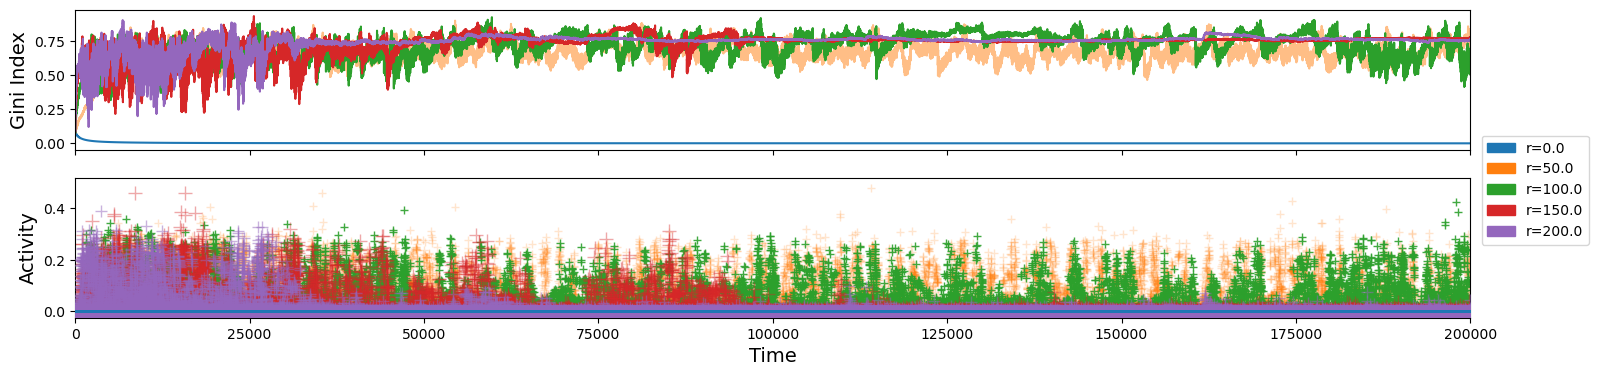

In [76]:
import matplotlib.patches as mpatches  
# Create a single figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(18, 4), sharex=True)
x_values = np.arange(iterations)
N = 100
# Upper panel
axs[0].plot(x_values, gini_indx[0], color='C0')
axs[0].plot(x_values, gini_indx[1], color='C1', alpha=0.5)
axs[0].plot(x_values, gini_indx[2], color='C2')
axs[0].plot(x_values, gini_indx[3], color='C3')
axs[0].plot(x_values, gini_indx[4], color='C4')

axs[0].set_xlim(0,200000)
# Create colored boxes for the legend
legend_handles_upper = [
    mpatches.Patch(color='C0', label=f'r={r_values[0]}'),
    mpatches.Patch(color='C1', label=f'r={r_values[1]}'),
    mpatches.Patch(color='C2', label=f'r={r_values[2]}'),
    mpatches.Patch(color='C3', label=f'r={r_values[3]}'),
    mpatches.Patch(color='C4', label=f'r={r_values[4]}'),
]
axs[0].legend(handles=legend_handles_upper,bbox_to_anchor=(1.09, 0.15))
# Add labels and omit legend
axs[0].set_ylabel('Gini Index', fontsize=14)

# Lower panel
axs[1].plot(x_values, activity[0]/((N-1)**2), color='C0', ls=" ", marker='+', alpha=1, markersize=1, zorder=4)
axs[1].plot(x_values, activity[1]/((N-1)**2), color='C1', ls=" ", marker='+', alpha=0.2, zorder=0)
axs[1].plot(x_values, activity[2]/((N-1)**2), color='C2', ls=" ", marker='+', alpha=0.9, zorder=1)
axs[1].plot(x_values, activity[3]/((N-1)**2), color='C3', ls=" ", marker='+', alpha=0.4, markersize=10, zorder=2)
axs[1].plot(x_values, activity[4]/((N-1)**2), color='C4', ls=" ", marker='+', alpha=0.5, markersize=8, zorder=3)

# Add labels and legend to the lower panel
axs[1].set_xlabel('Time', fontsize=14)
axs[1].set_ylabel('Activity', fontsize=14)

# Show the plots
plt.show()


In [58]:
filename1 = 'Gini-r5-Sim2-N100.npy'
filename2 = 'Act-r5-Sim2-N100.npy'
# Save the array to the specified filename
np.save(filename1, gini_indx)
np.save(filename2, activity)

# Phase diagram - Plots

In [13]:
def plot_colored_grid(array, x_top, y_top, textx, texty):
    # Create x and y values
    xx, yy = array.shape
    x_values = np.linspace(0, x_top, xx)
    y_values = np.linspace(0, y_top, yy)

    # Create a meshgrid for the heatmap
    x, y = np.meshgrid(x_values, y_values)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(x, y, array, cmap='plasma')
    plt.colorbar()

    # Set axis labels and title
    plt.xlabel(textx, fontsize = 20)
    plt.ylabel(texty, fontsize = 20)

    # Show the plot
    plt.show()

In [14]:
def phase_plots(array1, array2, x_space, y_space, textx, texty):
    # Create x and y values
    x_min, x_top = x_space
    y_min, y_top = y_space
    xx, yy = array1.shape
    x_values = np.linspace(x_min, x_top, xx)
    y_values = np.linspace(y_min, y_top, yy)

    # Create a meshgrid for the heatmap
    x, y = np.meshgrid(x_values, y_values)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    # Plot the first panel
    im1 = axs[0].pcolormesh(x, y, array1, cmap='plasma')
    #axs[0].set_title('Gini')
    axs[0].set_xlabel(textx, fontsize=20)
    axs[0].set_ylabel(texty, fontsize=20)
    cbar1 = plt.colorbar(im1, ax=axs[0])
    axs[0].text(-0.1, .95, 'a)', ha='center', va='center', transform=axs[0].transAxes, fontsize=20)

    # Plot the second panel
    im2 = axs[1].pcolormesh(x, y, array2, cmap='inferno')
    #axs[1].set_title('Activity')
    axs[1].set_xlabel(textx, fontsize=20)
    axs[1].set_ylabel(texty, fontsize=20)
    cbar2 = plt.colorbar(im2, ax=axs[1])
    axs[1].text(-0.1, .95, 'b)', ha='center', va='center', transform=axs[1].transAxes, fontsize=20)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


In [15]:
filenamekr1 = 'outputfolder/GiniMean-Grid25x25-kr-Sim20-N100.npy'
filenamekr2 = 'outputfolder/GiniStd-Grid25x25-kr-Sim20-N100.npy'
filenamekr3 = 'outputfolder/ActMean-Grid25x25-kr-Sim20-N100.npy'
filenamekr4 = 'outputfolder/ActStd-Grid25x25-kr-Sim20-N100.npy'

filenamerq1 = 'outputfolder/GiniMean-Grid25x25-rq-Sim20-N100.npy'
filenamerq2 = 'outputfolder/GiniStd-Grid25x25-rq-Sim20-N100.npy'
filenamerq3 = 'outputfolder/ActMean-Grid25x25-rq-Sim20-N100.npy'
filenamerq4 = 'outputfolder/ActStd-Grid25x25-rq-Sim20-N100.npy'

#filenametest1 = 'outputfolder/phase_data/GiniMean-Grid20x20-kr-Sim20-N100.npy'
#filenametest2 = 'outputfolder/phase_data/GiniStd-Grid20x20-kr-Sim20-N100.npy'
# filenametest3 = 'outputfolder/phase_data/ActMean-Grid20x20-kr-Sim20-N100.npy'
# filenametest4 = 'outputfolder/phase_data/ActStd-Grid20x20-kr-Sim20-N100.npy'

filenamerd1 = 'outputfolder/phase_data/GiniMean-Grid25x25-rd-Sim20-N100.npy'
filenamerd2 = 'outputfolder/phase_data/GiniStd-Grid25x25-rd-Sim20-N100.npy'
filenamerd3 = 'outputfolder/phase_data/ActMean-Grid25x25-rd-Sim20-N100.npy'
filenamerd4 = 'outputfolder/phase_data/ActStd-Grid25x25-rd-Sim20-N100.npy'


gini_mean_kr = np.load(filenamekr1)
gini_std_kr = np.load(filenamekr2)
act_mean_kr = np.load(filenamekr3)
act_std_kr = np.load(filenamekr4)

gini_mean_rq = np.load(filenamerq1)
gini_std_rq = np.load(filenamerq2)
act_mean_rq = np.load(filenamerq3)
act_std_rq = np.load(filenamerq4)

# gini_mean_kr_low = np.load(filenametest1)
# gini_std_kr_low = np.load(filenametest2)
# act_mean_kr_low = np.load(filenametest3)
# act_std_kr_low = np.load(filenametest4)

gini_mean_rd = np.load(filenamerd1)
gini_std_rd = np.load(filenamerd2)
act_mean_rd = np.load(filenamerd3)
act_std_rd = np.load(filenamerd4)

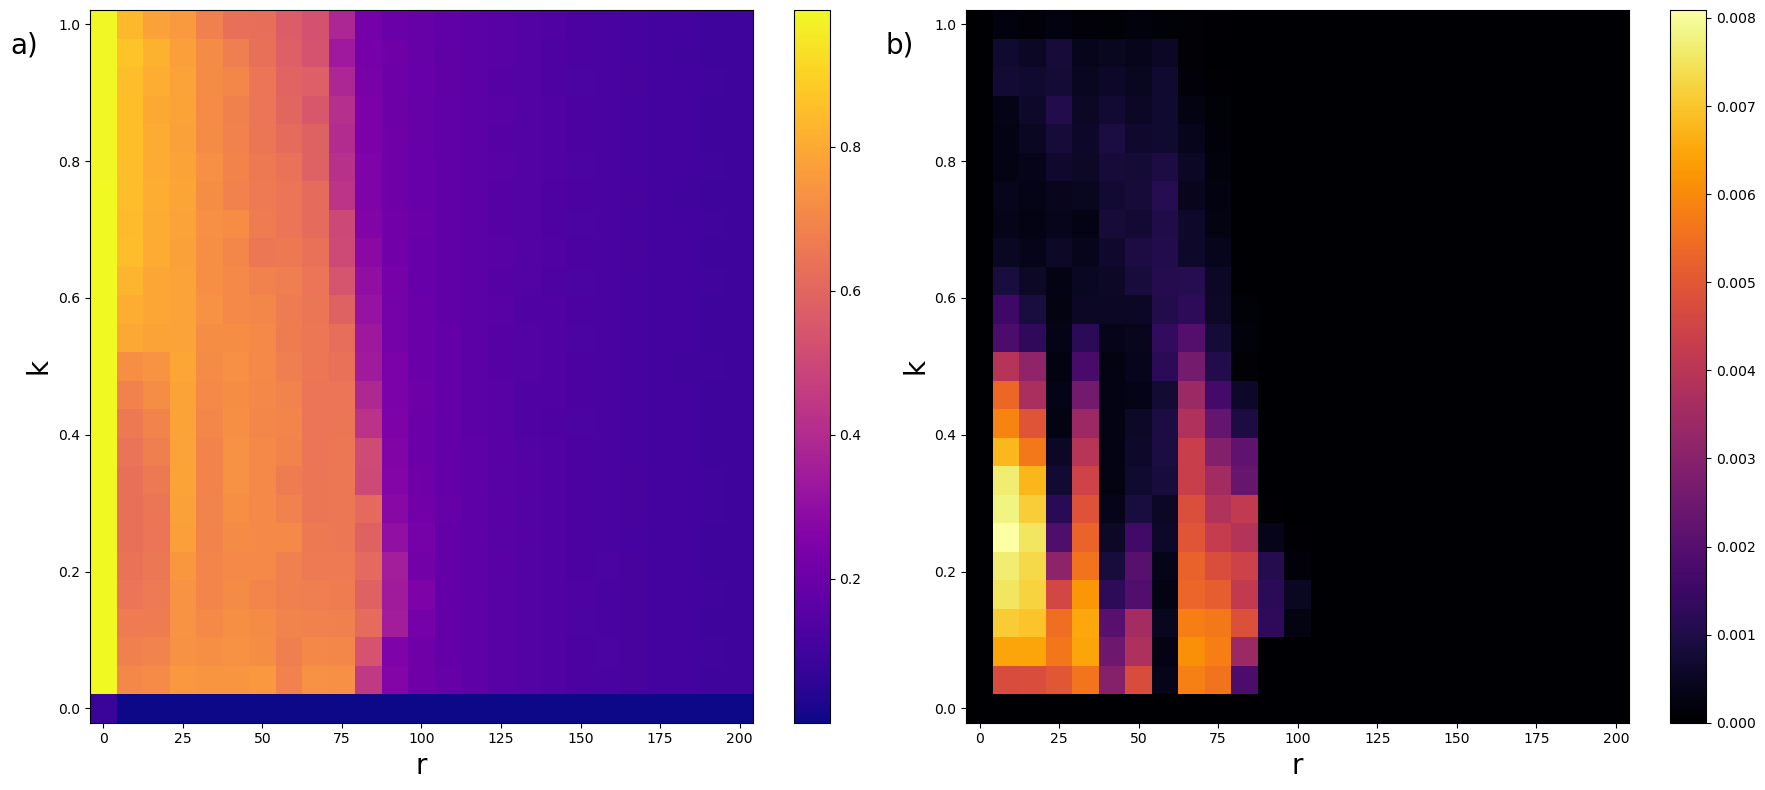

In [17]:
phase_plots(gini_mean_kr, act_mean_kr/(99**2), (0,200), (0,1),"r","k")

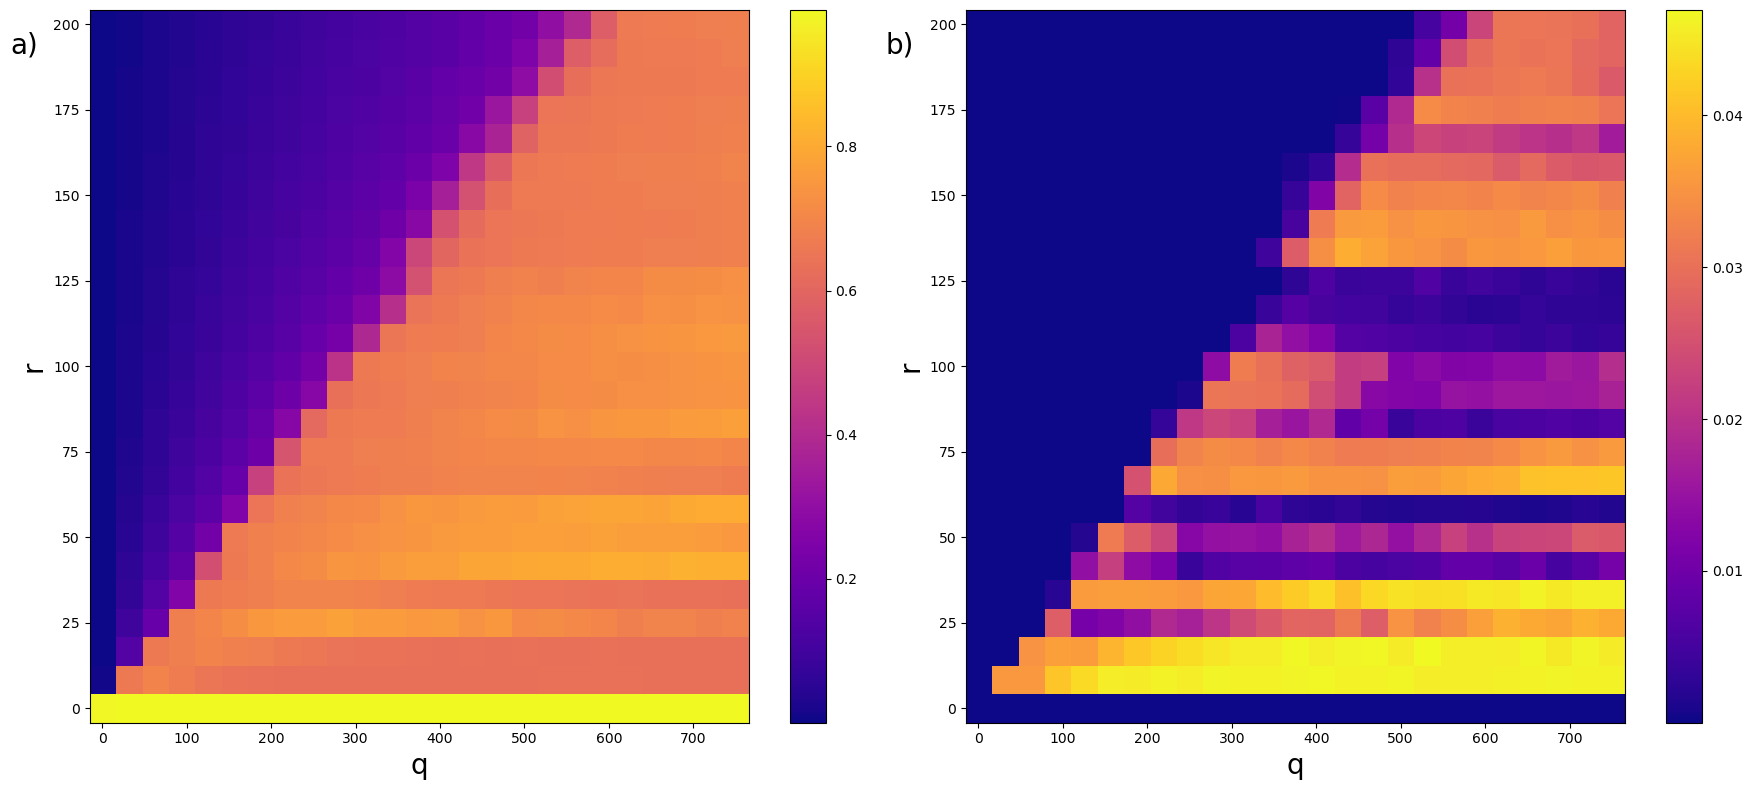

In [37]:
phase_plots(gini_mean_rq, act_std_rq/(99**2),  (1,750), (0,200),"q","r")

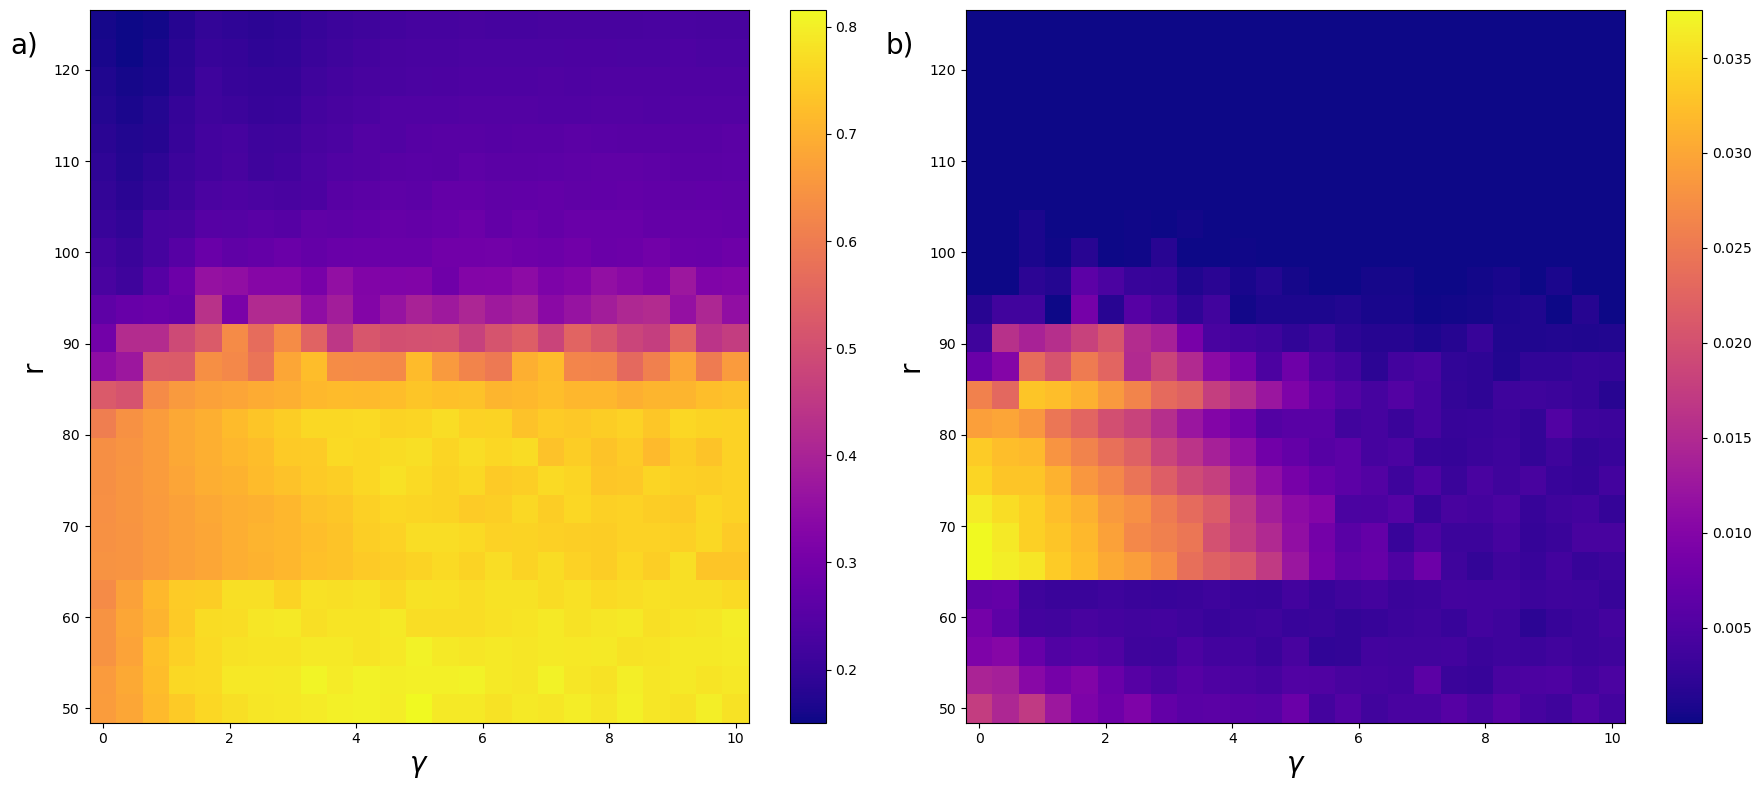

In [39]:
phase_plots(gini_mean_rd, act_std_rd/(99**2), (0,10), (50,125),u"$\gamma$","r")